## Setup the simple metric computation

Move current directory to project root

In [49]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import pandas as pd
df = pd.read_csv("wandb_exports/scaling_r_7.5_press_1e-6.csv")
# negate the entire "relative-dimensionality" column
set(df['name'])

{'cifar10_vs_cifar10_test_rectors',
 'cifar10_vs_svhn_test_boardroom',
 'svhn_vs_cifar10_test_reduplicated',
 'svhn_vs_svhn_test_imperiled'}

In [51]:
%autoreload 2
from ood.evaluation.utils import parse_table, get_roc_curves, get_auc

all_task_tables = parse_table(df)

In [52]:
def compute_slope(x, y):
    if len(x) != len(y):
        return "The lengths of x and y must be the same."
    
    N = len(x)
    
    # Calculate the sum of x, y, x*y and x*x
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_xx = np.sum(x * x)
    
    # Calculate the slope using the formula
    numerator = N * sum_xy - sum_x * sum_y
    denominator = N * sum_xx - sum_x ** 2
    
    if denominator == 0:
        return "Denominator cannot be zero."
    
    m = numerator / denominator
    
    return m

In [70]:
def project_onto_line(x, y, slope):
    slope = - 1/slope
    if len(x) != len(y):
        return "The lengths of x and y must be the same."

    # Create 2D point array from x and y
    points = np.array([x, y]).T  # shape will be (N, 2)
    
    # Line's direction vector [1, slope]
    line_vector = np.array([1, slope])  # shape will be (2,)
    # Project points onto the line
    line_vector_norm = np.linalg.norm(line_vector)  # norm of line_vector
    line_unit_vector = line_vector / line_vector_norm  # unit vector along line_vector
    
    
    projections = points @ line_unit_vector.reshape(-1, 1)
    return projections.flatten()

100%|██████████| 100/100 [00:00<00:00, 115896.77it/s]

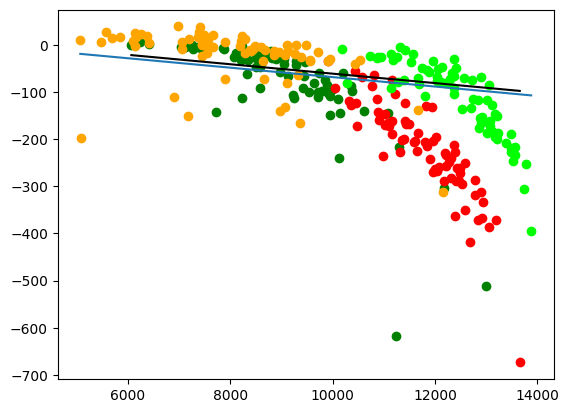

In [71]:
import matplotlib.pyplot as plt
from tqdm import tqdm

cifar_vs_svhn = all_task_tables['cifar10']['svhn']
# print all the unique values in column 'name' of cifar_vs_svhn
in_idx = cifar_vs_svhn['name'].str.startswith('test')
ood_idx = cifar_vs_svhn['name'].str.startswith('ood')

x_in = cifar_vs_svhn[in_idx]['log-likelihood'].values
y_in = cifar_vs_svhn[in_idx]['dimensionality (d-D)'].values
x_out = cifar_vs_svhn[ood_idx]['log-likelihood'].values
y_out = cifar_vs_svhn[ood_idx]['dimensionality (d-D)'].values

import numpy as np
# scaling_factor = np.mean(y_in) / np.mean(x_in)
# x_in *= scaling_factor
# x_out *= scaling_factor

plt.scatter(x_in, y_in, label="in", c="green")
plt.scatter(x_out, y_out, label="out", c="red")
all_x = np.concatenate([x_in, x_out])
all_y = np.concatenate([y_in, y_out])
mn_x, mn_y = np.min(all_x), np.min(all_y)
mx_x, mx_y = np.max(all_x), np.max(all_y)
slope = -0.01  #compute_slope(x_in, y_in)

pathology_projections = project_onto_line(x_in, y_in, slope), project_onto_line(x_out, y_out, slope), 
 
L, R = -1000, 1000

for _ in tqdm(range(100)):
    mid = (L + R) / 2
    pred_y = x_in * slope + mid
    rate = np.sum(pred_y > y_in) / len(y_in)
    if rate < 0.5:
        L = mid
    else:
        R = mid

plt.plot([mn_x, mx_x], [mn_x * slope + L, mx_x * slope + L], c='black')

cifar_vs_svhn = all_task_tables['svhn']['cifar10']
# print all the unique values in column 'name' of cifar_vs_svhn
in_idx = cifar_vs_svhn['name'].str.startswith('test')
ood_idx = cifar_vs_svhn['name'].str.startswith('ood')

x_in = cifar_vs_svhn[in_idx]['log-likelihood'].values
y_in = cifar_vs_svhn[in_idx]['dimensionality (d-D)'].values
x_out = cifar_vs_svhn[ood_idx]['log-likelihood'].values
y_out = cifar_vs_svhn[ood_idx]['dimensionality (d-D)'].values

import numpy as np
# scaling_factor = np.mean(y_in) / np.mean(x_in)
# x_in *= scaling_factor
# x_out *= scaling_factor

import matplotlib.pyplot as plt
from tqdm import tqdm

plt.scatter(x_in, y_in, label="in", c="lime")
plt.scatter(x_out, y_out, label="out", c="orange")
all_x = np.concatenate([x_in, x_out])
all_y = np.concatenate([y_in, y_out])
mn_x, mn_y = np.min(all_x), np.min(all_y)
mx_x, mx_y = np.max(all_x), np.max(all_y)
slope = -0.01 #compute_slope(x_in, y_in)


normal_projections = project_onto_line(x_in, y_in, slope), project_onto_line(x_out, y_out, slope), 
 

L, R = -1000, 1000

for _ in tqdm(range(100)):
    mid = (L + R) / 2
    pred_y = x_in * slope + mid
    rate = np.sum(pred_y > y_in) / len(y_in)
    if rate < 0.5:
        L = mid
    else:
        R = mid

plt.plot([mn_x, mx_x], [mn_x * slope + L, mx_x * slope + L])
plt.show()

In [72]:
pathology_projections[0]

array([ 5.26385216e+01, -4.38002246e+01, -2.89359312e-01,  7.57754026e+01,
        7.29359894e+01,  5.87566354e+01,  7.07489051e+01,  2.48305554e+01,
       -2.04421786e+00,  5.13504092e+01, -1.03707393e+02,  7.98919187e+01,
        6.09370407e+01, -1.41317422e+01,  6.76357127e+01,  5.61586590e+01,
        6.73578331e+01,  3.74157452e+01,  6.24870948e+00,  6.64737911e+01,
        5.00535156e+01, -3.81251148e+02,  4.17859648e+01,  6.60967927e+01,
        6.41226875e+01,  7.32627954e+01,  3.80906199e+01,  1.60664184e+01,
        3.91755393e+01,  6.14488402e+01,  6.28776578e+01,  1.56383157e+01,
        6.77644341e+01, -5.45044678e+00, -3.35614445e+01,  2.93782653e+01,
        5.64808694e+01, -5.04369741e+02,  6.58883012e+01,  4.93790425e+01,
        5.75905648e+01,  6.95273128e+01, -4.98952470e+00, -2.78463616e+00,
        7.58405647e+01, -1.93709568e+01, -8.51400821e+00,  6.84424635e+01,
        7.11529452e+01,  6.49504818e+00,  6.15159265e+01,  3.23719567e+01,
        5.97726001e+01,  

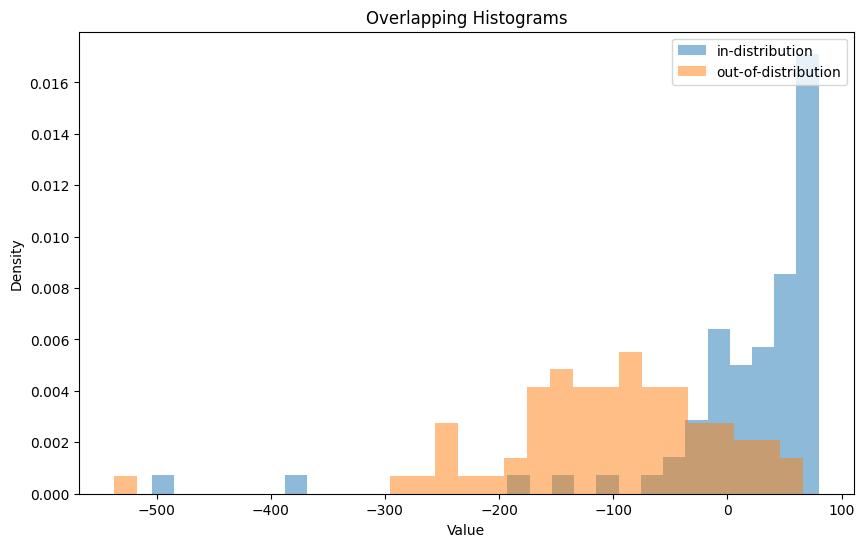

In [74]:
plt.figure(figsize=(10, 6))

# Plot histogram for 'x'
plt.hist(pathology_projections[0], bins=30, alpha=0.5, label='in-distribution', density=True)

# Plot histogram for 'y'
plt.hist(pathology_projections[1], bins=30, alpha=0.5, label='out-of-distribution', density=True)

# Add title and labels
plt.title('Pathology')
plt.xlabel('Value')
plt.ylabel('Density')

# Add a legend
plt.legend(loc='upper right')

plt.show()

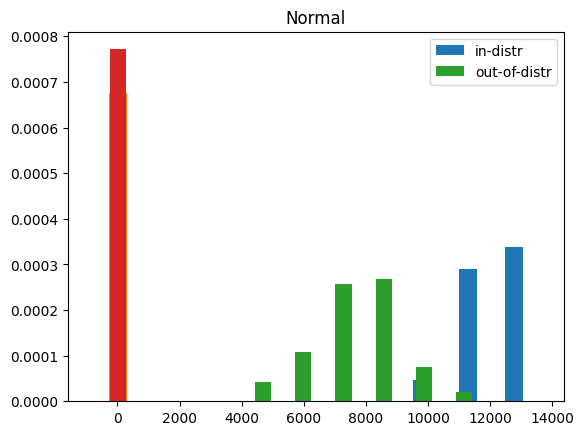

In [57]:
plt.hist(normal_projections[0], density=True, label="in-distr")
plt.hist(normal_projections[1], density=True, label="out-of-distr")
plt.title("Normal")
plt.legend()
plt.show()

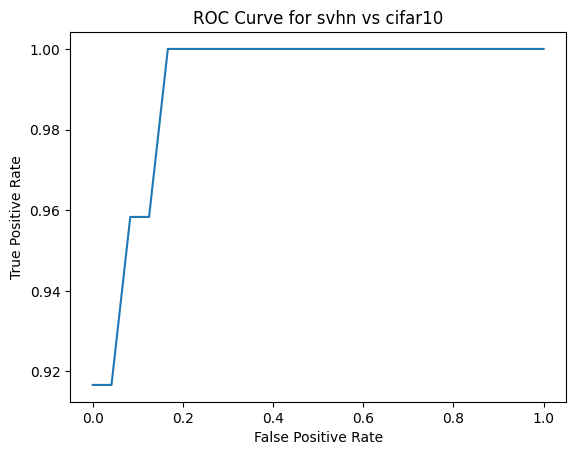

AUC: 0.9913194444444445


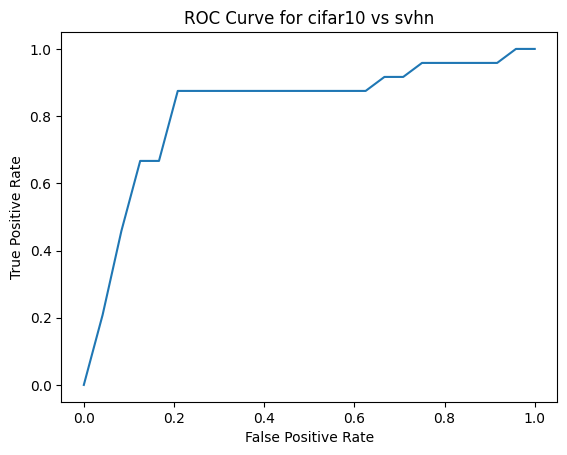

AUC: 0.8229166666666669


In [34]:
for first_part in all_task_tables.keys():
    for second_part in all_task_tables[first_part].keys():
        df = all_task_tables[first_part][second_part]
        fp, tp = get_roc_curves(df, "relative-dimensionality", "likelihood")['train-vs-ood']
        
        plt.plot(fp, tp)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for {} vs {}".format(first_part, second_part))
        plt.show()
        print("AUC: {}".format(get_auc(fp, tp)))

In [29]:
svhn_vs_cifar10 = all_task_tables['svhn']['cifar10']

In [30]:
res = get_auc_curves(svhn_vs_cifar10, "relative-dimensionality", "likelihood")

In [31]:
fp, tp = res['train-vs-ood']

Text(0, 0.5, 'True Positive Rate')

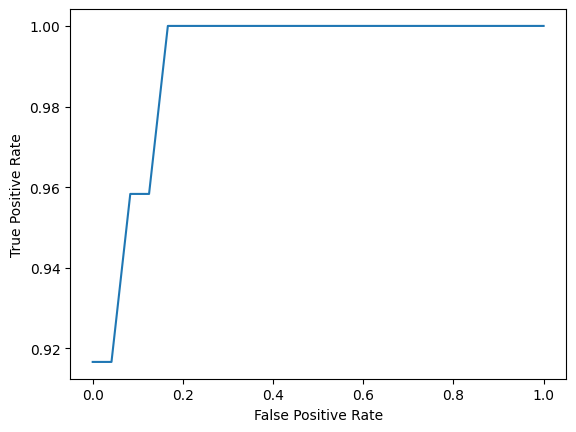

In [32]:
from matplotlib import pyplot as plt
